# Speeding up the objective function calculation using numba

The objective function is evaluated over and over again and it makes sense to spent some time to make it faster. Here we use the just-in-time compilation option from `numba`.


## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum. 

## Objective function calculation

Naive implementation with nested loops. This is $O(n^2)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math

In [2]:
def conflicts_naive(board):
    """Caclulate the number of conflicts, i.e., the objective function."""
    
    board = np.array(board)
    
    n = len(board)
    val = 0

    # check horizontal (we do not check vertical since the state space is restricted to one queen per col)
    for i in range(n): val += math.comb(np.sum(board == i), 2)
    #print(f"Horizontal value: {val}")
    
    # check for each queen diagonally up and down (only to the right side of the queen)
    for j in range(n):
        q_up = board[j]
        q_down = board[j]
     
        for jj in range(j+1, n):
            q_up -= 1
            q_down += 1
            if board[jj] == q_up: val += 1
            if board[jj] == q_down: val += 1
        #print(f"Value after queen {j}: {val}")
       
    return(val)    

A better implementation that should be $O(n)$. Idea: 

1. Count how many queens are in each row (no need to check columns) and how many are in each diagonal.
2. Convert the number of $n$ queens in a row (diagonal) into the numbner of pariwise conflicts in $n$ choose 2. We use a faster special case for the `comb()` function to calcualte the conflicts given the number of queens.   

In [3]:
def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Caclulate the number of conflicts, i.e., the objective function."""

    n = len(board)
    
    horizontal_cnt = [0] * n
    # we have double the diagonals compared to columns!
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n
    
    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1
    
    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))

We can use just-in-time compilation for the conflicts function. Code provided by Troy McNitt.

In [4]:
from numba import njit

# with jit (cannot use some Python functions like sum)
@njit()
def comb2_jit(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

@njit()
def conflicts_jit(board):
    """Caclulate the number of conflicts, i.e., the objective function."""

    n = len(board)
 
    cnt = [0] * (5 * n)
 
    for i in range(n):
        cnt[board[i]] += 1
        cnt[(n) + (i + board[i])] += 1
        cnt[(3 * n) + (i - board[i] + n)] += 1
 
    conflicts = 0
    for x in cnt:
        conflicts += comb2_jit(x)
 
    return conflicts

# Compare Timing

Compare runtime on 50 random boards of different sizes.

In [5]:
np.random.seed(1234)
def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""
    
    return(np.random.randint(0,n, size = n))

In [10]:
import timeit
 
# run it once to compile
conflicts_jit(random_board(4))
    
x = []
naive_times = []
linear_times = []
jit_times = []
 
 
for i in range(50, 500, 50):
    boards = [random_board(i) for _ in range(50)]
 
    #print(f"Doing: {i}")

    naive = timeit.timeit(
        lambda: [conflicts_naive(board) for board in boards], number=1
    )
    linear = timeit.timeit(
        lambda: [conflicts(board) for board in boards], number=1
    )
    jit = timeit.timeit(
        lambda: [conflicts_jit(board) for board in boards], number=1
    )

 
    x.append(i)
    naive_times.append(naive)
    linear_times.append(linear)
    jit_times.append(jit)
 

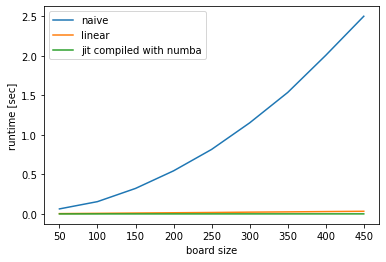

In [11]:
plt.plot(x, naive_times)
plt.plot(x, linear_times)
plt.plot(x, jit_times)
plt.xlabel("board size")
plt.ylabel("runtime [sec]")
plt.legend(["naive", "linear", "jit compiled with numba"])
plt.show()

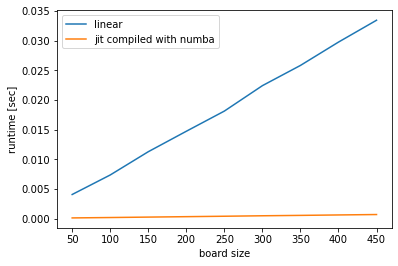

In [12]:
plt.plot(x, linear_times)
plt.plot(x, jit_times)
plt.xlabel("board size")
plt.ylabel("runtime [sec]")
plt.legend(["linear", "jit compiled with numba"])
plt.show()